In [22]:
import numpy as np
  
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers import concatenate, LeakyReLU, BatchNormalization, Dense, Flatten, Activation, Reshape, Dropout
from keras.optimizers import *
from keras.datasets import mnist

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

import h5py
import glob
import imageio

import os
from skimage.io import imsave

(X_train, _), (_, _) = mnist.load_data()
X_train = np.reshape(X_train, (-1, 28, 28, 1))/255

In [42]:
image_size = 28

def build_generator(image_size):
    input1 = Input(shape=(None, None, 1))
#     input2 = Flatten()(input1)
#     model = Dense(256)(input2)
#     model = LeakyReLU(alpha=0.2)(model)
#     model = BatchNormalization(momentum=0.8)(model)
#     model = Dense(512)(model)
#     model = LeakyReLU(alpha=0.2)(model)
#     model = BatchNormalization(momentum=0.8)(model)
#     model = Dense(1024)(model)
#     model = LeakyReLU(alpha=0.2)(model)
#     model = BatchNormalization(momentum=0.8)(model)
#     model = Dense(image_size*image_size)(model)
#     model = LeakyReLU(alpha=0.2)(model)
#     model = BatchNormalization(momentum=0.8)(model)
#     model = Reshape((image_size,image_size,1))(model)
    input11 = UpSampling2D()(input1)
    model1 = Conv2D(16, (3, 3), strides=(1, 1), padding='same')(input11)
    model1 = LeakyReLU(alpha=0.2)(model1)
    model1 = BatchNormalization(momentum=0.8)(model1)
    model1 = Conv2D(16, (3, 3), strides=(1, 1), padding='same')(model1)
    model1 = LeakyReLU(alpha=0.2)(model1)
    model1 = BatchNormalization(momentum=0.8)(model1)
    
    model2 = Conv2D(32, (3, 3), strides=(2, 2), padding='same')(model1)
    model2 = LeakyReLU(alpha=0.2)(model2)
    model2 = BatchNormalization(momentum=0.8)(model2)
    model2 = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(model2)
    model2 = LeakyReLU(alpha=0.2)(model2)
    model2 = BatchNormalization(momentum=0.8)(model2)
    model2 = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(model2)
    model2 = LeakyReLU(alpha=0.2)(model2)
    model2 = BatchNormalization(momentum=0.8)(model2)

    model3 = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(model2)
    model3 = LeakyReLU(alpha=0.2)(model3)
    model3 = BatchNormalization(momentum=0.8)(model3)
    model3 = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(model3)
    model3 = LeakyReLU(alpha=0.2)(model3)
    model3 = BatchNormalization(momentum=0.8)(model3)
    model3 = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(model3)
    model3 = LeakyReLU(alpha=0.2)(model3)
    model3 = BatchNormalization(momentum=0.8)(model3)

    model4 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(model3), model2], axis=3)
    model4 = LeakyReLU(alpha=0.2)(model4)
    model4 = BatchNormalization(momentum=0.8)(model4)
    model4 = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(model4)
    model4 = LeakyReLU(alpha=0.2)(model4)
    model4 = BatchNormalization(momentum=0.8)(model4)
    model4 = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(model4)
    model4 = LeakyReLU(alpha=0.2)(model4)
    model4 = BatchNormalization(momentum=0.8)(model4)
    
    model5 = concatenate([Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(model4), model1], axis=3)
    model5 = LeakyReLU(alpha=0.2)(model5)
    model5 = BatchNormalization(momentum=0.8)(model5)
    model5 = Conv2D(16, (3, 3), strides=(1, 1), padding='same')(model5)
    model5 = LeakyReLU(alpha=0.2)(model5)
    model5 = BatchNormalization(momentum=0.8)(model5)
    model5 = Conv2D(16, (3, 3), strides=(1, 1), padding='same')(model5)
    model5 = LeakyReLU(alpha=0.2)(model5)
    model5 = BatchNormalization(momentum=0.8)(model5)
    
#     model6 = concatenate([Conv2D(16, (1, 1), padding='same')(model5), model], axis=3)
#     model6 = LeakyReLU(alpha=0.2)(model6)
#     model6 = BatchNormalization(momentum=0.8)(model6)
    model6 = concatenate([Conv2D(16, (1, 1), padding='same')(model5), input11], axis=3)
    model6 = LeakyReLU(alpha=0.2)(model6)
    model6 = BatchNormalization(momentum=0.8)(model6)
    model6 = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(model6)
    
    return Model(inputs=input1, outputs=model6)

def build_discriminator(image_size):
    input1 = Input(shape=(None, None, 1))
    input2 = Input(shape=(None, None, 1))
    
    model1 = UpSampling2D()(input1)
    model1 = Conv2D(16, (3, 3), strides=(1,1), padding='same')(model1)
    model1 = LeakyReLU(alpha=0.2)(model1)
    model1 = BatchNormalization(momentum=0.8)(model1)
    model1 = Conv2D(16, (3, 3), strides=(1,1), padding='same')(model1)
    model1 = LeakyReLU(alpha=0.2)(model1)
    model1 = BatchNormalization(momentum=0.8)(model1)
    
    model = Conv2D(16, (3, 3), strides=(1,1), padding='same')(input2)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    model = Conv2D(16, (3, 3), strides=(1,1), padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    model = concatenate([model, model1], axis=3)
    
    model = Conv2D(32, (3, 3), strides=(2,2), padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    model = Conv2D(64, (3, 3), strides=(1,1), padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    model = Conv2D(64, (3, 3), strides=(1,1), padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    
    model = Conv2D(128, (3, 3), strides=(2,2), padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    model = Conv2D(256, (3, 3), strides=(1,1), padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    model = Conv2D(256, (3, 3), strides=(1,1), padding='same')(model)
    model = GlobalAveragePooling2D()(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
#     model = Flatten()
    model = Dense(1024)(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    model = Dense(512)(model)
    model = LeakyReLU(alpha=0.2)(model)
#     model = BatchNormalization(momentum=0.8)
    model = Dense(1)(model)
    model = Activation('sigmoid')(model)

    return Model(inputs=[input1, input2], outputs=model)

optimizer = Adam(0.001, 0.5)
generator = build_generator(image_size)
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

optimizer1 = Adam(0.0002, 0.5)
discriminator = build_discriminator(image_size)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer1, metrics=['accuracy'])

discriminator.trainable = False

# The generator takes noise as input and generated imgs
z = Input(shape=(None, None, 1))
img = generator(z)
# The valid takes generated images as input and determines validity
valid = discriminator([z, img])

# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity 
combined = Model(z, [valid, img])
combined.compile(loss=['binary_crossentropy', 'mean_absolute_error'], optimizer=optimizer, metrics = ['accuracy'])

combined.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_71 (InputLayer)           (None, None, None, 1 0                                            
__________________________________________________________________________________________________
model_53 (Model)                (None, None, None, 1 165318      input_71[0][0]                   
__________________________________________________________________________________________________
model_54 (Model)                (None, 1)            1824769     input_71[0][0]                   
                                                                 model_53[1][0]                   
Total params: 1,990,087
Trainable params: 164,260
Non-trainable params: 1,825,827
__________________________________________________________________________________________________


C:\Users\Daniel\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.655591, acc.: 70.00%] [G loss: 0.937885]


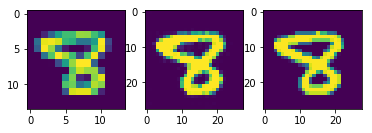

10 [D loss: 0.479130, acc.: 71.00%] [G loss: 2.688483]


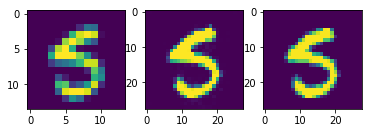

20 [D loss: 1.247568, acc.: 22.00%] [G loss: 2.386960]


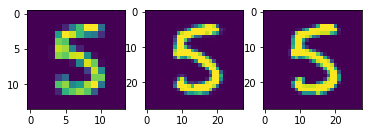

30 [D loss: 0.456590, acc.: 86.00%] [G loss: 2.052290]


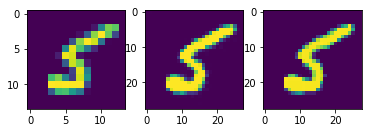

40 [D loss: 0.468036, acc.: 71.00%] [G loss: 2.485298]


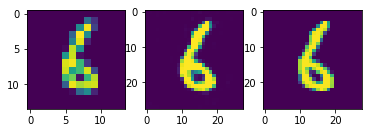

50 [D loss: 0.211115, acc.: 96.00%] [G loss: 2.030803]


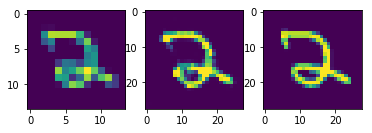

60 [D loss: 1.055592, acc.: 43.00%] [G loss: 2.986531]


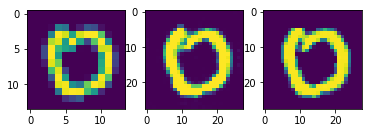

70 [D loss: 0.316453, acc.: 93.00%] [G loss: 1.996390]


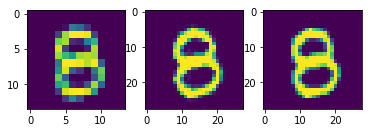

80 [D loss: 0.653854, acc.: 60.00%] [G loss: 3.248325]


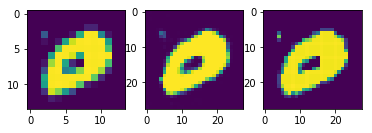

90 [D loss: 0.191733, acc.: 98.00%] [G loss: 2.883720]


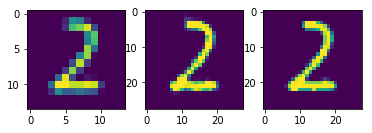

100 [D loss: 0.419231, acc.: 73.00%] [G loss: 3.965743]


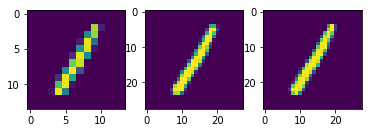

110 [D loss: 0.407933, acc.: 89.00%] [G loss: 2.623350]


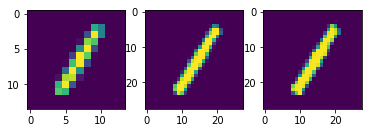

120 [D loss: 0.610895, acc.: 65.00%] [G loss: 2.075436]


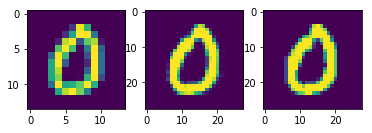

130 [D loss: 0.560126, acc.: 71.00%] [G loss: 2.579497]


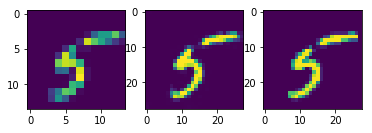

140 [D loss: 0.298408, acc.: 96.00%] [G loss: 2.078156]


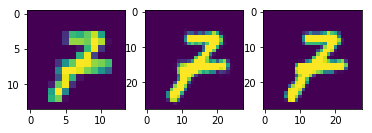

150 [D loss: 0.670499, acc.: 56.00%] [G loss: 2.115996]


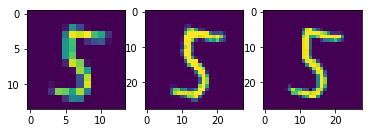

160 [D loss: 0.320254, acc.: 98.00%] [G loss: 2.521275]


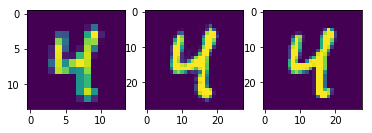

170 [D loss: 0.480497, acc.: 62.00%] [G loss: 4.423592]


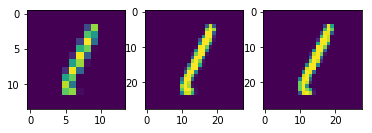

180 [D loss: 0.362645, acc.: 91.00%] [G loss: 1.846556]


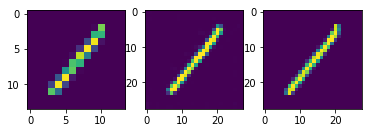

190 [D loss: 0.419221, acc.: 77.00%] [G loss: 3.186538]


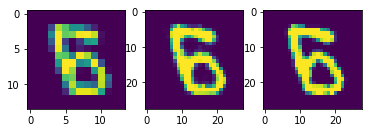

200 [D loss: 0.283200, acc.: 96.00%] [G loss: 3.132966]


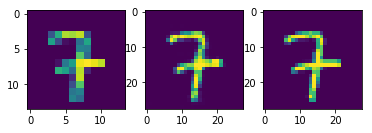

210 [D loss: 0.260138, acc.: 92.00%] [G loss: 2.009397]


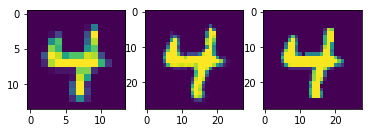

220 [D loss: 0.434275, acc.: 85.00%] [G loss: 2.893071]


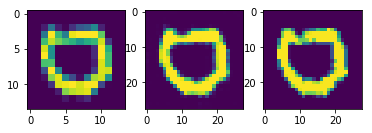

230 [D loss: 0.995371, acc.: 23.00%] [G loss: 3.481755]


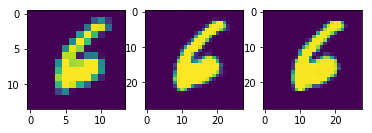

240 [D loss: 0.432934, acc.: 82.00%] [G loss: 2.441839]


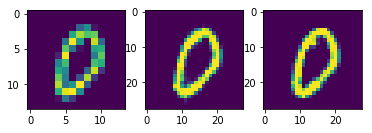

250 [D loss: 0.290124, acc.: 95.00%] [G loss: 2.482220]


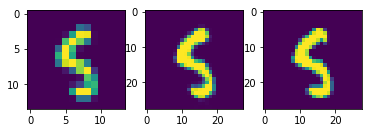

260 [D loss: 0.341582, acc.: 89.00%] [G loss: 2.613692]


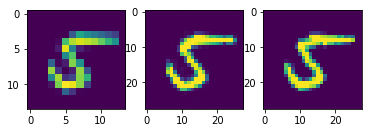

270 [D loss: 0.210842, acc.: 100.00%] [G loss: 1.086498]


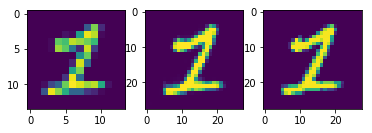

280 [D loss: 0.063792, acc.: 98.00%] [G loss: 2.595231]


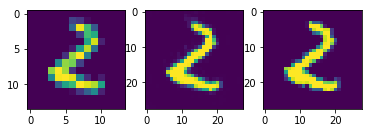

290 [D loss: 1.446781, acc.: 14.00%] [G loss: 2.636154]


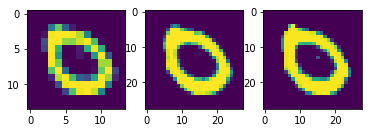

300 [D loss: 0.447987, acc.: 74.00%] [G loss: 4.535644]


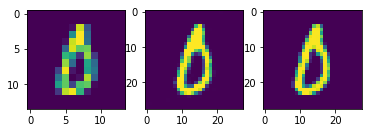

310 [D loss: 1.669403, acc.: 1.00%] [G loss: 4.547989]


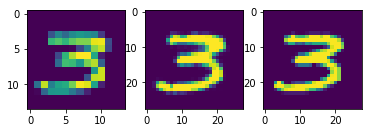

320 [D loss: 0.592475, acc.: 69.00%] [G loss: 3.477962]


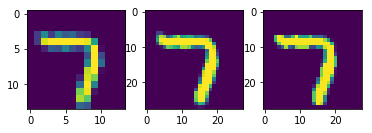

330 [D loss: 0.216380, acc.: 96.00%] [G loss: 2.723004]


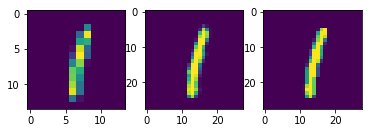

340 [D loss: 0.282174, acc.: 100.00%] [G loss: 2.091095]


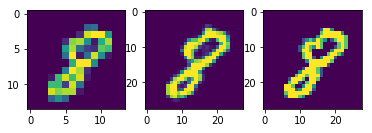

350 [D loss: 0.262110, acc.: 97.00%] [G loss: 3.369320]


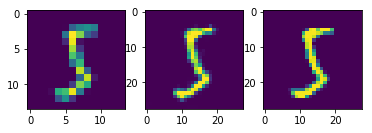

360 [D loss: 0.268908, acc.: 97.00%] [G loss: 2.706942]


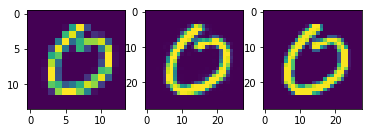

370 [D loss: 1.673548, acc.: 10.00%] [G loss: 2.191634]


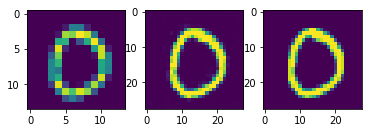

380 [D loss: 0.327993, acc.: 98.00%] [G loss: 1.977361]


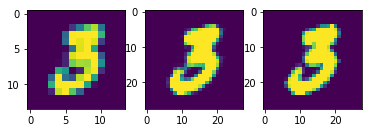

390 [D loss: 0.780847, acc.: 66.00%] [G loss: 4.012261]


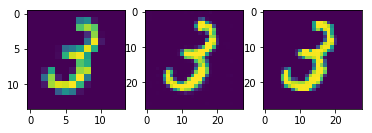

400 [D loss: 0.223356, acc.: 90.00%] [G loss: 3.358095]


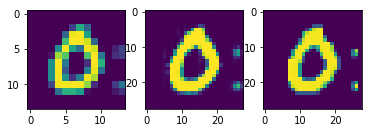

410 [D loss: 0.159516, acc.: 100.00%] [G loss: 1.889258]


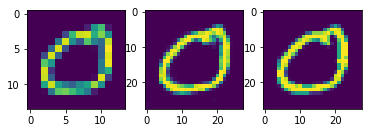

420 [D loss: 1.671939, acc.: 8.00%] [G loss: 3.658577]


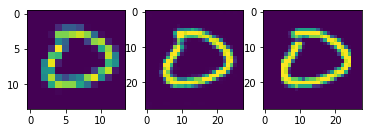

430 [D loss: 0.253321, acc.: 99.00%] [G loss: 2.417705]


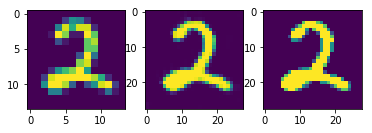

440 [D loss: 0.050783, acc.: 100.00%] [G loss: 3.610311]


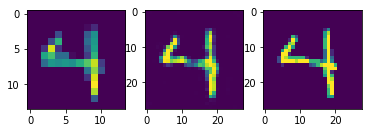

450 [D loss: 0.155333, acc.: 99.00%] [G loss: 3.539373]


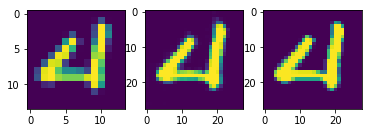

460 [D loss: 0.626872, acc.: 62.00%] [G loss: 2.777096]


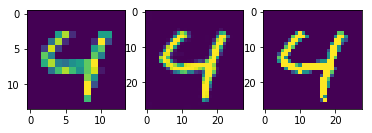

470 [D loss: 0.739358, acc.: 50.00%] [G loss: 3.955361]


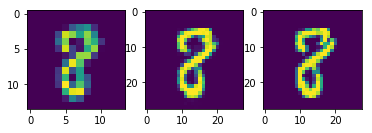

480 [D loss: 0.661913, acc.: 61.00%] [G loss: 3.345160]


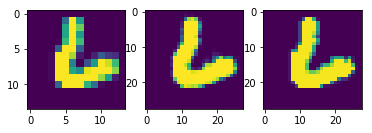

490 [D loss: 0.194067, acc.: 97.00%] [G loss: 1.757594]


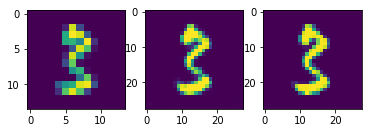

In [44]:
epochs = 500
batch_size = 100
half_batch = int(batch_size/2)
def reduce_resolution(ims):
    O, M, N, P = ims.shape
    K = 2
    L = 2

    MK = M // K
    NL = N // L
    return ims.reshape(-1, MK, K, NL, L).mean(axis=(2, 4)).reshape(O, MK, NL, P)
def upsize(ims):
    return ims.repeat(2, axis = 1).repeat(2, axis = 2)
for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random half batch of images
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]
    noise = reduce_resolution(imgs)

    idx1 = np.random.randint(0, X_train.shape[0], half_batch)
    imgs1 = X_train[idx1]
    noise1 = reduce_resolution(imgs1)

    # Generate a half batch of new images
    gen_imgs = generator.predict(noise1)
    # Train the discriminator
    
    d_loss_real = discriminator.train_on_batch([noise, imgs], np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch([noise1, gen_imgs], np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------

    idx2 = np.random.randint(0, X_train.shape[0], batch_size)
    noise2 = reduce_resolution(X_train[idx2])

    # The generator wants the discriminator to label the generated samples
    # as valid (ones)
    valid_y = np.array([1] * batch_size)
    
    # Train the generator
    g_loss = combined.train_on_batch(noise2, [valid_y, X_train[idx2]])
        
    if epoch % 10 == 0:
        # Plot the progress
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0]))
        fig, ax = plt.subplots(1, 3)
        ax[0].imshow(np.reshape(noise1[0], (14, 14)))
        ax[1].imshow(np.reshape(gen_imgs[0], (28, 28)))
        ax[2].imshow(np.reshape(imgs1[0], (28, 28)))
        plt.show()


In [ ]:
generator.save('generator_mnist.h5')
discriminator.save('discriminator_mnist.h5')
combined.save('combined_mnist.h5')